<a href="https://colab.research.google.com/github/rangelokk/Diplom/blob/main/Version_archive/RNM/ResnetMini2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import kagglehub
import cv2
import keras.callbacks
import numpy as np
from keras.utils import to_categorical
from PIL import Image
import seaborn as sns
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [ ]:
height = 64
width = 64
chanels = 3
input_shape = (height, width, chanels)  # Замените height и width на ваши размеры изображений
num_classes = 7  # Замените на количество классов вашей задачи
num_additional_features = 1  # Например, возраст и пол

### Загрузка данных

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
data = pd.read_csv(path + "/HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
def read_image(file_path):
  img = cv2.imread(path + '/HAM10000_images_part_2/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  if (img is None):
    img = cv2.imread(path + '/HAM10000_images_part_1/'+file_path+'.jpg', cv2.IMREAD_COLOR)
  return cv2.resize(img, (height, width), interpolation=cv2.INTER_CUBIC)

In [ ]:
data['Image'] = data['image_id'].apply(read_image)
data['age'].fillna((data['age'].median()), inplace=True)
data

<ipython-input-116-94a310f2e3e8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna((data['age'].median()), inplace=True)


,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[198, 156, 193], [194, 153, 188], [190, 145,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[25, 12, 21], [27, 14, 23], [42, 25, 36], [7..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[[[138, 129, 185], [148, 134, 191], [160, 147,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[17, 10, 23], [30, 20, 34], [47, 35, 63], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[[[118, 95, 140], [139, 114, 159], [163, 134, ..."
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,"[[[163, 152, 165], [156, 142, 159], [142, 123,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,"[[[1, 6, 4], [9, 9, 9], [8, 7, 9], [25, 28, 32..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,"[[[109, 108, 118], [124, 127, 143], [114, 118,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,"[[[145, 128, 156], [129, 109, 154], [157, 134,..."


In [ ]:
X_t, Test = train_test_split(data, test_size=0.2, random_state=42)
Train, Val = train_test_split(X_t, test_size=0.25, random_state=42)

In [ ]:
Train

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
482,HAM_0005146,ISIC_0030346,bkl,histo,60.0,male,face,"[[[100, 86, 127], [104, 97, 133], [103, 97, 13..."
7123,HAM_0007477,ISIC_0032007,nv,histo,25.0,male,back,"[[[201, 201, 231], [207, 207, 231], [208, 209,..."
6581,HAM_0007071,ISIC_0030449,nv,follow_up,35.0,female,trunk,"[[[169, 158, 235], [165, 154, 235], [172, 154,..."
6991,HAM_0001767,ISIC_0025812,nv,histo,50.0,female,lower extremity,"[[[165, 145, 164], [168, 146, 165], [165, 142,..."
6333,HAM_0003907,ISIC_0027587,nv,follow_up,60.0,male,upper extremity,"[[[144, 127, 218], [141, 125, 219], [126, 111,..."
...,...,...,...,...,...,...,...,...
9564,HAM_0004197,ISIC_0033467,nv,consensus,40.0,female,unknown,"[[[216, 208, 219], [219, 210, 221], [225, 214,..."
4666,HAM_0002304,ISIC_0024648,nv,follow_up,55.0,female,lower extremity,"[[[198, 172, 247], [198, 172, 245], [198, 174,..."
9382,HAM_0005712,ISIC_0025101,nv,consensus,5.0,female,foot,"[[[183, 146, 180], [184, 146, 182], [185, 144,..."
4070,HAM_0001206,ISIC_0031320,nv,follow_up,55.0,male,abdomen,"[[[165, 143, 225], [166, 140, 226], [164, 144,..."


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6009 entries, 482 to 7570
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     6009 non-null   object 
 1   image_id      6009 non-null   object 
 2   dx            6009 non-null   object 
 3   dx_type       6009 non-null   object 
 4   age           6009 non-null   float64
 5   sex           6009 non-null   object 
 6   localization  6009 non-null   object 
 7   Image         6009 non-null   object 
dtypes: float64(1), object(7)
memory usage: 422.5+ KB


### Сборка данных

In [ ]:
def prepare_data(images):
    m = len(images)
    print(m)
    X = np.zeros((m, height, width, chanels), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = image_file
    return X

In [ ]:
X_train = (prepare_data(Train['Image'])/255.).astype(np.float16)
X_test = (prepare_data(Test['Image'])/255.).astype(np.float16)
X_val = (prepare_data(Val['Image'])/255.).astype(np.float16)
print(X_train.dtype)

6009
2003
2003
float16


In [ ]:
class_labels = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'nv': 4,
    'vasc': 5,
    'mel': 6
}
Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=num_classes)
Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=num_classes)
Y_val = to_categorical(Val['dx'].replace(class_labels), num_classes=num_classes)

<ipython-input-122-eb22b42d0357>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = to_categorical(Train['dx'].replace(class_labels), num_classes=num_classes)
<ipython-input-122-eb22b42d0357>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = to_categorical(Test['dx'].replace(class_labels), num_classes=num_classes)
<ipython-input-122-eb22b42d0357>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_obj

In [ ]:
A_test = (Test['age']/85.).to_numpy().reshape(-1, 1).astype(np.float16)
A_train = (Train['age']/85.).to_numpy().reshape(-1, 1).astype(np.float16)
A_val = (Val['age']/85.).to_numpy().reshape(-1, 1).astype(np.float16)

In [ ]:

print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("A_train shape:", A_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)
print ("A_test shape:", A_test.shape)
print ("X_val shape:", X_val.shape)
print ("Y_val shape:", Y_val.shape)
print ("A_val shape:", A_val.shape)

number of training examples = 6009
number of test examples = 2003
X_train shape: (6009, 64, 64, 3)
Y_train shape: (6009, 7)
A_train shape: (6009, 1)
X_test shape: (2003, 64, 64, 3)
Y_test shape: (2003, 7)
A_test shape: (2003, 1)
X_val shape: (2003, 64, 64, 3)
Y_val shape: (2003, 7)
A_val shape: (2003, 1)


In [ ]:
Train['age'].info()

<class 'pandas.core.series.Series'>
Index: 6009 entries, 482 to 7570
Series name: age
Non-Null Count  Dtype  
--------------  -----  
6009 non-null   float64
dtypes: float64(1)
memory usage: 93.9 KB


## Модель

In [ ]:
def resnet_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])  # Добавляем вход (shortcut)
    x = layers.ReLU()(x)
    return x

def create_model(input_shape, num_classes, num_additional_features):
    inputs = layers.Input(shape=input_shape)

    # Начальный слой
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Блоки ResNet
    for _ in range(3):  # Меньше блоков для ускорения
        x = resnet_block(x, 32)

    # Глобальное усреднение
    x = layers.GlobalAveragePooling2D()(x)

    # Объединение с дополнительными признаками
    additional_inputs = layers.Input(shape=(num_additional_features,))
    combined = layers.concatenate([x, additional_inputs])

    # Полносвязный слой
    combined = layers.Dense(64, activation='relu')(combined)
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = models.Model(inputs=[inputs, additional_inputs], outputs=outputs)
    return model

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=20)
image_generator = datagen.flow([X_train, A_train], Y_train, batch_size=32, seed=1)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator,
    output_signature=(
        (tf.TensorSpec(shape=(None, *X_train.shape[1:]), dtype=tf.float32),
         tf.TensorSpec(shape=(None, *A_train.shape[1:]), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, Y_train.shape[1]), dtype=tf.float32)
    )
)

In [ ]:
# Пример тестирования генератора
for images in image_generator:
    print(images[0].)  # Должно быть (batch_size, высота, ширина, каналы)
    break  # Выход из цикла после первой итерации


[array([[[[0.5764212 , 0.5018336 , 0.8515521 ],
         [0.5688647 , 0.4980554 , 0.86666507],
         [0.58015674, 0.50935596, 0.8742386 ],
         ...,
         [0.5028423 , 0.4494192 , 0.8123122 ],
         [0.51276076, 0.45437843, 0.81838727],
         [0.5200506 , 0.45790386, 0.82287914]],

        [[0.5827667 , 0.5141662 , 0.8571808 ],
         [0.5708484 , 0.49904725, 0.8626977 ],
         [0.5771812 , 0.50638044, 0.8722549 ],
         ...,
         [0.49851608, 0.44534206, 0.81009305],
         [0.48661396, 0.43839917, 0.80302614],
         [0.4747118 , 0.43145624, 0.79595923]],

        [[0.58970964, 0.52805203, 0.8641237 ],
         [0.5728321 , 0.5000391 , 0.8587303 ],
         [0.5742057 , 0.5034049 , 0.8702712 ],
         ...,
         [0.4835394 , 0.4403265 , 0.8030425 ],
         [0.48849863, 0.44528574, 0.8070098 ],
         [0.49345785, 0.45024496, 0.8109772 ]],

        ...,

        [[0.5332031 , 0.55357075, 0.79310167],
         [0.5332031 , 0.55964583, 0.80116045

In [ ]:
model = create_model(input_shape, num_classes, num_additional_features)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
image_generator.x_misc

[array([[0.706  ],
        [0.2942 ],
        [0.4119 ],
        ...,
        [0.05884],
        [0.647  ],
        [0.4119 ]], dtype=float16)]

In [ ]:
bat = 0
hist_list = []
for x_batch, y_batch in image_generator:
  hist = model.fit(x_batch, y_batch, validation_data=([X_val, A_val], Y_val))
  print("Epoch: " + str(bat))
  bat +=1
  hist_list.append(hist)
  if bat>= len(X_train)/32:
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8438 - loss: 0.5442 - val_accuracy: 0.6955 - val_loss: 1.0209
Epoch: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step - accuracy: 0.7188 - loss: 0.6887 - val_accuracy: 0.7004 - val_loss: 0.9869
Epoch: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.6064 - val_accuracy: 0.6980 - val_loss: 0.9506
Epoch: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6875 - loss: 0.7950 - val_accuracy: 0.7009 - val_loss: 0.9094
Epoch: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7812 - loss: 0.7367 - val_accuracy: 0.6955 - val_loss: 0.8799
Epoch: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6875 - loss: 0.9526 - val_accuracy: 0.6965 - val_loss: 0.8543
Epoch: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step - accuracy: 0.7188 - loss: 0.7376 - val_accuracy: 0.6900 - val_loss: 0.8439
Epoch: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7188 - loss: 0.7319 - val_accuracy: 0.6840 - val_loss: 0.8539
Epoch: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:

 # Обучение модели
history = model.fit(x = [image_generator.x, image_generator.x_misc], y = image_generator.y, epochs=100,
    steps_per_epoch=len(X_train)//32,
    validation_data=([X_val, A_val], Y_val))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_450', 'keras_tensor_476']
Received: inputs=('Tensor(shape=(None, 64, 64, 3))', ('Tensor(shape=(None, 1))',))
  warnings.warn(msg)


183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7175 - loss: 0.7568

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.7176 - loss: 0.7565 - val_accuracy: 0.6405 - val_loss: 1.0132
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7252 - loss: 0.7525 - val_accuracy: 0.6800 - val_loss: 0.9135
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7367 - loss: 0.7288 - val_accuracy: 0.7104 - val_loss: 0.8385
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7327 - loss: 0.7177 - val_accuracy: 0.7284 - val_loss: 0.7821
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7453 - loss: 0.6756 - val_accuracy: 0.3749 - val_loss: 1.5646
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7487 - loss: 0.6779 - val_accuracy: 0.6191 - val_loss: 1.1402
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7442 - loss: 0.6685 - val_accuracy: 0.7319 - val_loss: 0.7366
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7493 - loss: 0.6708 - val_ac

## Оценки

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, roc_auc_score

preds = model.evaluate([X_test, A_test], Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

# Прогнозирование на тестовых данных
Y_pred = model.predict([X_test, A_test])
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Вычисление дополнительных метрик
accuracy  = preds[1]
loss = preds[0]
precision = precision_score(Y_true_classes, Y_pred_classes, average='weighted')
recall = recall_score(Y_true_classes, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true_classes, Y_pred_classes, average='weighted')
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
print("Precision = " + str(precision))
print("Recall = " + str(recall))
print("F1 Score = " + str(f1))
print("Mean Absolute Error (MAE) =", mae)
print("Mean Squared Error (MSE) =", mse)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7353 - loss: 0.7803
Loss = 0.7756136059761047
Test Accuracy = 0.7498751878738403
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Loss = 0.7756136059761047
Test Accuracy = 0.7498751878738403
Precision = 0.7432329437980228
Recall = 0.7498751872191712
F1 Score = 0.7317713104579406
Mean Absolute Error (MAE) = 0.08741168148992233
Mean Squared Error (MSE) = 0.051783594202483366


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Построение графиков потерь и точности
def plot_history(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss', color='green')
    plt.plot(history.history['val_loss'], label='val_loss', color='blue')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



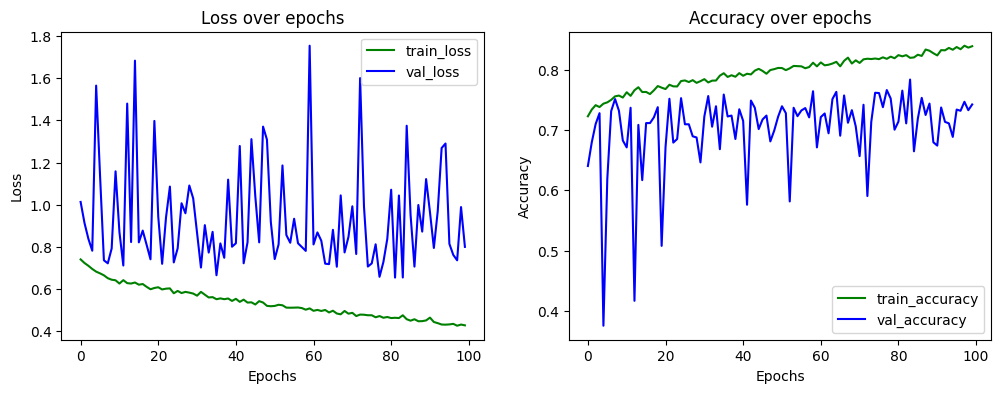

In [ ]:
# Вызов функции для построения графиков
plot_history(history)

AttributeError: 'list' object has no attribute 'history'

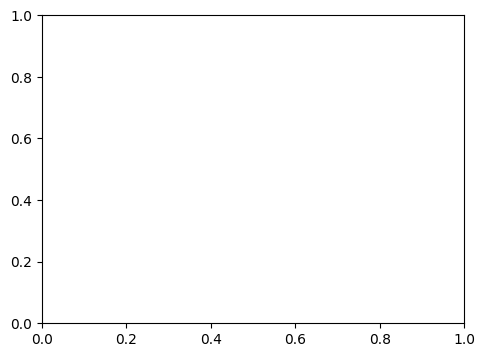

In [ ]:
plot_history(hist_list)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 32)     │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 178,839 (698.59 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 118,928 (464.57 KB)

### **Добавляем матрицу неточностей**

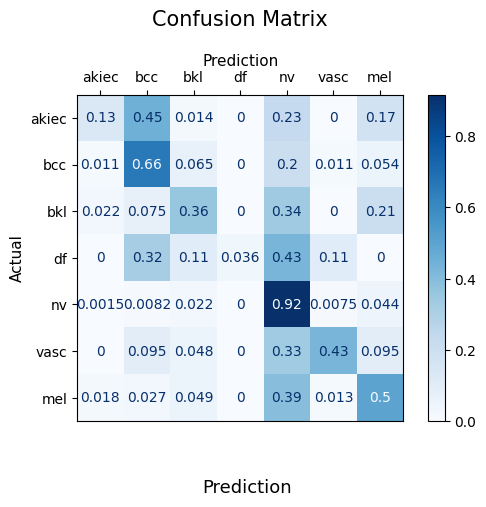

In [ ]:
# Помоги пожалуйста данные нужные вставить, если что, вот

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

class_names = ['akiec','bcc','bkl','df','nv','vasc','mel']

cm = confusion_matrix(Y_true_classes, Y_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6])
row_sum = cm.sum(axis=1, keepdims=True)
cm =cm / row_sum
##np.fill_diagonal(cm, 0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

In [ ]:
accuracy

0.6754867434501648

###Визуализация наших оценок в столбчатый график

Модель обучилась средне


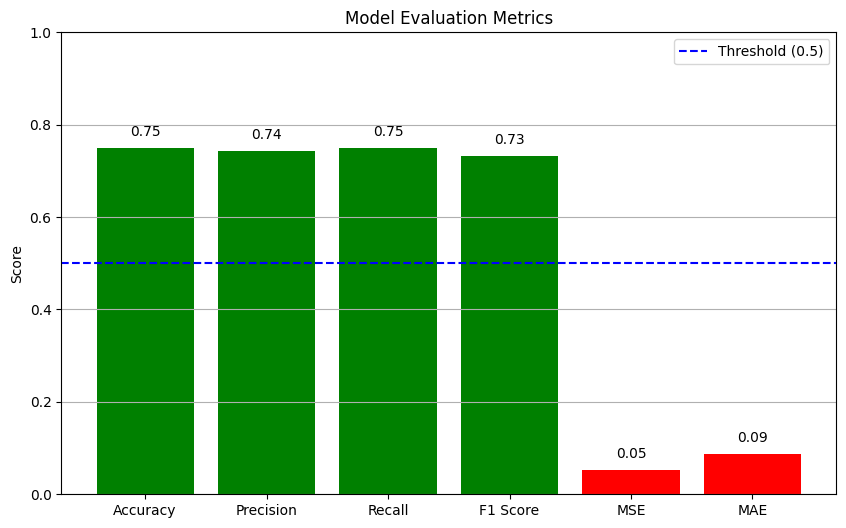

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(accuracy, precision, recall, f1_score, mse, mae):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE']
    values = [accuracy, precision, recall, f1_score, mse, mae]

    colors = ['green', 'green', 'green', 'green', 'red', 'red']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=colors)

    plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold (0.5)')

    plt.title('Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, max(max(values), 1))

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

    plt.legend()
    plt.grid(axis='y')

    if accuracy >= 0.8 and precision >= 0.8 and recall >= 0.8 and f1_score >= 0.8:
        print("Модель обучилась хорошо")
    elif accuracy >= 0.5:
        print("Модель обучилась средне")
    else:
        print("Модель обучилась плохо")

    plt.show()

plot_metrics(accuracy, precision, recall, f1, mse, mae)

### Попытка построить ROC-AUC кривую

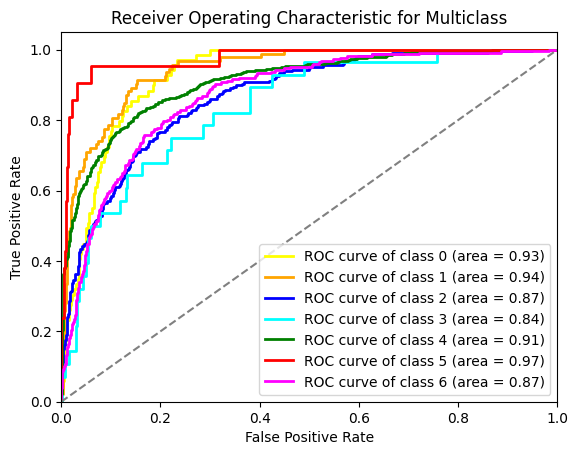

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Строим ROC-кривую
plt.figure()
colors = ['yellow', 'orange', 'blue', 'cyan', 'green', 'red', 'magenta']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('ResNetMini.keras')